In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
# import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med-1.5")

from llava.model.builder import load_pretrained_model
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

from PIL import Image
import random
import math

from utils import show_image_relevance

/data/aofei/conda/env/llava_v1.5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/aofei/conda/env/llava_v1.5/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


[2025-01-08 16:13:56,378] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
model_path = "/data/aofei/LLM/llava-med-v1.5-mistral-7b"

# load the model
load_8bit = False
load_4bit = False
device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import set_seed
set_seed(0)
disable_torch_init()

# model_name = get_model_name_from_path(model_path)
model_name = "mistral_llava_med_1.5"
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path,
    None,  # model_base
    model_name,
    device=device
)

/data/aofei/conda/env/llava_v1.5/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
Some weights of the model checkpoint at /data/aofei/LLM/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm

In [3]:
get_local.clear()
torch.cuda.empty_cache()

H, W = 24, 24
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

## No training

In [4]:
def get_attention_weights_example(model, question, image_path, conv_mode="plain"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    # cur_prompt = qs
    # qs = question
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    print(prompt)
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image = Image.open(image_path)

    # image_tensor, images = process_images([image], image_processor, model.config)
    # image = images[0]
    # image_size = image.size

    image_tensor = process_images([image], image_processor, model.config)[0]

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            # image_sizes=[image_size],
            do_sample=False,
            max_new_tokens=64,
            use_cache=True,
            return_dict_in_generate=True,
            output_attentions=True,
            output_scores=True,
            # stopping_criteria=[stopping_criteria]
        )
    text = tokenizer.decode(outputs["sequences"][0]).strip()
    print(text)

    cache = get_local.cache

    return cache, text, outputs, input_ids, image

In [10]:
get_local.clear()
torch.cuda.empty_cache()
question = "Does the image show any signs of liver cancer?"
image_path = "/home/avc6555/research/MedH/visualize/llava_visualize/images/med/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<image>
Does the image show any signs of liver cancer?

<s>
 The ct scan of the abdomen does not show any signs of liver cancer. </s>


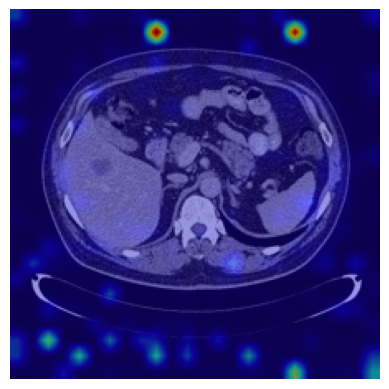

In [11]:
# IMAGE_TOKEN_INDEX
img_token_idx = int(torch.where(input_ids == -200)[1])
img_token_idx
for i in range(3, 5):
    attn_all_layers = cache['MistralSdpaAttention.forward'][32*(i+1):32*(i+2)]
    token = tokenizer.decode(outputs["sequences"][0][i])
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)
    # fig.savefig(f'vis_med/tokens/img_{i}_{token}.png',dpi=300,bbox_inches='tight')

In [7]:
model_copy1 = copy.deepcopy(model)

In [8]:
lora_path = "/data/aofei/hallucination/mitigation/IU_Xray/llava_med_1.5/lora_report/epoch12/seed4/checkpoints"
peft_path = lora_path
if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy1 = PeftModel.from_pretrained(model_copy1, peft_path)
    print(f"Merging weights")
    model_copy1 = model_copy1.merge_and_unload()

Loading LoRA weights from /data/aofei/hallucination/mitigation/IU_Xray/llava_med_1.5/lora_report/epoch12/seed4/checkpoints
Merging weights


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>
Analyze the chest X-ray and generate a concise medical report. ASSISTANT:
<s> The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.</s>


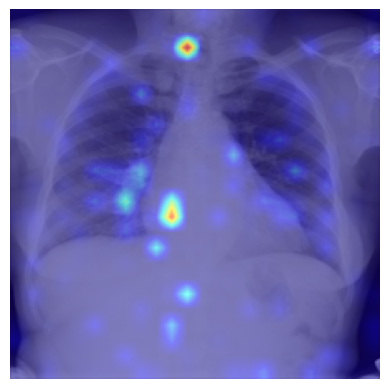

In [9]:
get_local.clear()
torch.cuda.empty_cache()
# question = "What color is the spleen in the picture?"
question = "Analyze the chest X-ray and generate a concise medical report."
# question = "Does the picture contain liver?"
# question = "Does the picture contain lungs?"
image_path = "/home/avc6555/research/MedH/visualize/llava_visualize/images/med/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path, conv_mode="v1")

# bbox = 0.1
img_token_idx = int(torch.where(input_ids == -200)[1])
img_token_idx
for i in range(0, 1):
    attn_all_layers = cache['MistralSdpaAttention.forward'][32*(i+1):32*(i+2)]
    token = tokenizer.decode(outputs["sequences"][0][i])
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

## Moe on Slake

In [12]:
from llava.model.moe_llava import LoRA_MOE_FFN, LoRA_MOE_QK, LoRA_MOE_QK_old

In [13]:
# peft_path = "/data/aofei/hallucination/mitigation/Slake/llava_med_1.5/ours_v1/expert_8_16_rank16_8_lora_0_bbox_0.03/head128/epoch6_seed4/checkpoints"
# peft_path="/data/aofei/hallucination/mitigation/Slake/llava_med_1.5/ours_v1_search/expert_8_16_rank16_8_lora_0_bbox_0.01/head128/epoch6_seed4/checkpoints"
# peft_path = "/data/aofei/hallucination/mitigation/Slake/llava_med_1.5/ours_v2_search/expert_8_16_rank16_8_lora_0_bbox_0.06/head128/epoch6_seed4/checkpoints"
# peft_path = "/data/aofei/hallucination/mitigation/VQA_RAD/llava_med_1.5/ours_v2_true/balance_0.01_expert_8_16_rank16_8_lora_0_bbox_0.03/head128/epoch9_seed4/checkpoints"
peft_path = "/data/aofei/hallucination/mitigation/IU_Xray_report/llava_med_1.5/ours_v1/top128_balance_top2/all_expert_1_8_rank16/lora_0_bbox_0.05/epoch12_seed4/checkpoints"
lora_r, lora_alpha = 16, 8
# q_expert_num, k_expert_num = 8, 16
q_expert_num, k_expert_num = 1, 8
dense_moe, top_exp_num = True, 2
if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model = PeftModel.from_pretrained(model, peft_path)
    print(f"Merging weights")
    model = model.merge_and_unload()
    
    moe_path = os.path.join(peft_path, "non_lora_trainables.bin")
    moe_state_dict = torch.load(moe_path, map_location='cuda')
    if len(moe_state_dict.keys()) > 32:
        print("load MoE parameters!")
        num_layers = len(model.base_model.layers)
        for i in range(num_layers):
            original_q = model.base_model.layers[i].self_attn.q_proj
            model.base_model.layers[i].self_attn.q_proj = \
                LoRA_MOE_QK(args=None,
                    lora_rank=lora_r,
                    lora_alpha=lora_alpha,
                    num_experts=q_expert_num,
                    original_module=original_q,
                    dense_moe=dense_moe).bfloat16()
            original_k = model.base_model.layers[i].self_attn.k_proj
            model.base_model.layers[i].self_attn.k_proj = \
                LoRA_MOE_QK_old(args=None,
                    lora_rank=lora_r,
                    lora_alpha=lora_alpha,
                    num_experts=k_expert_num,
                    top_moe_experts=top_exp_num,
                    original_module=original_k).bfloat16()
            
        new_state_dict = {}
        for key, value in moe_state_dict.items():
            # Replace "base_model.model" with an empty string to remove it
            new_key = key.replace("base_model.model", "")
            if new_key.startswith("."):
                new_key = new_key[1:]
            new_state_dict[new_key] = value.to("cuda")
            # new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict, strict=False)
        model = model.to("cuda")
        for key in new_state_dict.keys():
            # if "mm_projector" in key:
            #     continue
            assert torch.equal(model.state_dict()[key], new_state_dict[key]), f"Mismatch in {key}, {model.state_dict()[key].dtype}, {new_state_dict[key].dtype}"
        print("Subset loaded successfully.")
        print('Convert to FP16...')
        model.to(torch.float16)
    elif len(moe_state_dict.keys()) > 1:
        new_state_dict = {}
        for key, value in moe_state_dict.items():
            # Replace "base_model.model" with an empty string to remove it
            new_key = key.replace("base_model.model", "")
            if new_key.startswith("."):
                new_key = new_key[1:]
            new_state_dict[new_key] = value.to("cuda")
        model.load_state_dict(new_state_dict, strict=False)
        print("Projector loaded successfully.")
        model = model.to("cuda")
        # for key in new_state_dict.keys():
        #     print(model.state_dict()[key], "cernijvj" ,new_state_dict[key])
        #     assert torch.equal(model.state_dict()[key], new_state_dict[key]), f"Mismatch in {key}"
        model.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/IU_Xray_report/llava_med_1.5/ours_v1/top128_balance_top2/all_expert_1_8_rank16/lora_0_bbox_0.05/epoch12_seed4/checkpoints
Merging weights
load MoE parameters!
Subset loaded successfully.
Convert to FP16...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>
Analyze the chest X-ray and generate a concise medical report. ASSISTANT:
<s> The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.</s>


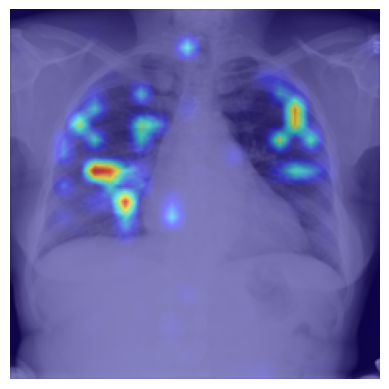

In [14]:
get_local.clear()
torch.cuda.empty_cache()
# question = "What color is the spleen in the picture?"
question = "Analyze the chest X-ray and generate a concise medical report."
# question = "Does the picture contain liver?"
# question = "Does the picture contain lungs?"
image_path = "/home/avc6555/research/MedH/visualize/llava_visualize/images/med/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path, conv_mode="v1")

# bbox = 0.1
img_token_idx = int(torch.where(input_ids == -200)[1])
img_token_idx
for i in range(0, 1):
    attn_all_layers = cache['MistralSdpaAttention.forward'][32*(i+1):32*(i+2)]
    token = tokenizer.decode(outputs["sequences"][0][i])
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+H*W].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)